# Capstone Project - Applied Data Science

## 1. Introduction/Business Problem

Currently Brexit is affecting the City of London and many financial institutions are moving to other cities in Europe (a popular one is Paris) in order to continue servicing the European customers without interruptions and amendments. As a result many financial institutions are asking their employees to move to these cities. Let's explore which areas of these cities are similar to the areas of London, so the employers can give an informed advice to the employees.

The goal of these project is to examine which areas of the other two cities are similar to areas of London. Based on this clustering the employees will be able either to choose the most similar area to the one they live now, or have an informed comparison while choosing the area of their new home.

The approach we will follow is to cluster the areas of each city based on the venue types they are near. By clustering the areas of London we can identify the common features of each area. To do this we will utilise the k-means clustering algorithm. Once we create the main clusters we will run the algorithm for areas in Paris and classify each area based on the clusters created earlier. Someone can use this results to look for areas during the transition to look for areas similar to the her/his current location.

## 2. Data Requirements and Collection

The data we are going to need are the several districts of London and Paris. We are going to acquire these form the following links:
* London: https://www.milesfaster.co.uk/london-postcodes-list.htm
* Paris: https://www.annuaire-administration.com/code-postal/region/ile-de-france.html

Additionally, we will need the data related with the venues in its city. We are going to acquire these by using the Foursquare API as required by the instructions of this project.

Importing Libraries.

In [1]:
import requests

import pandas as pd
import numpy as np

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import matplotlib.cm as cm
import matplotlib.colors as colors

import json 
from pandas.io.json import json_normalize

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [2]:
url='https://www.milesfaster.co.uk/london-postcodes-list.htm'
url

'https://www.milesfaster.co.uk/london-postcodes-list.htm'

In [3]:
raw_data=requests.get(url).text

We import BeautifulSoup to arrange the data we downloaded as HTML.

In [4]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(raw_data,'lxml')
#print(soup.prettify())

We use find attribute to find the table in the website.

In [5]:
my_table = soup.find('table',{'class':'noborder'})
#my_table

We define the columns of our new table which will include the postcodes and district names.

In [6]:
headings=('Postcodes','Districts')
postcodes=[]
districts=[]

We extract the raw data from the lxml format.

In [7]:
for i in range(0,len(my_table.findAll('td'))-1,2):
    if (my_table.findAll('td')[i].text.replace('\n','').strip()!=''):
        postcodes.append(my_table.findAll('td')[i].text.replace('\n','').strip())
        districts.append(my_table.findAll('td')[i+1].text.replace('\n','').strip())

We create a pandas dataframe where we store the postcode and district data for London.

In [8]:
data_london={headings[0]:postcodes,headings[1]:districts}
df_ldn=pd.DataFrame(data_london)
df_ldn

,Postcodes,Districts
0,E1,"Whitechapel, Stepney, Mile End"
1,SE1,"Waterloo, Bermondsey, Southwark, Borough"
2,E1W,Wapping
3,SE2,Abbey Wood
4,E2,"Bethnal Green, Shoreditch"
...,...,...
116,NW10,"Willesden, Harlesden, Kensal Green"
117,W12,Shepherds Bush
118,NW11,"Golders Green, Hampstead Gdn Suburb"
119,W13,West Ealing


We notice that for some Districts there are more than one areas. We expand the table to examine each area separately.

In [9]:
headings2=('Postcodes','Areas')
postcodes2=[]
areas=[]
for postcode in df_ldn['Postcodes']:
    for area in df_ldn.loc[df_ldn['Postcodes']==postcode,'Districts'].item().split(','):
        postcodes2.append(postcode)
        areas.append(area.strip())
data_london={headings2[0]:postcodes2,headings2[1]:areas}
df_ldn2=pd.DataFrame(data_london)
df_ldn2     

/Users/markoslolos/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: `item` has been deprecated and will be removed in a future version
  """


,Postcodes,Areas
0,E1,Whitechapel
1,E1,Stepney
2,E1,Mile End
3,SE1,Waterloo
4,SE1,Bermondsey
...,...,...
201,W12,Shepherds Bush
202,NW11,Golders Green
203,NW11,Hampstead Gdn Suburb
204,W13,West Ealing


Let's find now the latitude and longitude of each area. We also update the dataframe with the data from London with the geographical coordinates of each area.

In [10]:
latitudes=[]
longitudes=[]

Below is the code we created to download the data using Nominatim. However, this function has download restrictions so we saved the data later to have access at any time without the need to call the function every time.

In [11]:
#geolocator = Nominatim(user_agent="my-application")
#for i in range(0,len(df_ldn2)):
#    location = geolocator.geocode(df_ldn2['Areas'][i]+' '+df_ldn2['Postcodes'][i]+' '+'London'+' '+'United Kingdom',timeout=60)
#    if (location is None):
#        location = geolocator.geocode(df_ldn2['Areas'][i]+' '+'United Kingdom',timeout=60)
#    if (location is None):
#        location = geolocator.geocode(df_ldn2['Postcodes'][i]+' '+'London'+' '+'United Kingdom',timeout=60)
#    latitudes.append(location.latitude)
#    longitudes.append(location.longitude)
#df_ldn2['Latitude']=latitudes
#df_ldn2['Longitude']=longitudes

We export the dataframe to csv so we don't have to use the Nominatim() service again as it has usage constriants.

In [12]:
#df_ldn2.to_csv('/Users/markoslolos/Google Drive (markoslolos1@gmail.com)/Data Science IBM/Applied Data Science Capstone/Applied-Data-Science-Capstone/df_ldn2.csv',index=False)

In [13]:
df_ldn2=pd.read_csv('/Users/markoslolos/Google Drive (markoslolos1@gmail.com)/Data Science IBM/Applied Data Science Capstone/Applied-Data-Science-Capstone/df_ldn2.csv')
df_ldn2

,Postcodes,Areas,Latitude,Longitude
0,E1,Whitechapel,51.518623,-0.062081
1,E1,Stepney,51.517402,-0.046219
2,E1,Mile End,51.525091,-0.035047
3,SE1,Waterloo,51.502881,-0.112090
4,SE1,Bermondsey,51.497700,-0.064345
...,...,...,...,...
201,W12,Shepherds Bush,51.505314,-0.222901
202,NW11,Golders Green,51.571832,-0.195522
203,NW11,Hampstead Gdn Suburb,51.580508,-0.180616
204,W13,West Ealing,51.510413,-0.323524


In [14]:
df_ldn2.dtypes

Postcodes     object
Areas         object
Latitude     float64
Longitude    float64
dtype: object

Create a map of London using Folium library.

In [15]:
#!pip install folium
import folium # map rendering library

Let's get the coordinates of London to create the London map.

In [16]:
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
ldn_latitude = location.latitude
ldn_longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(ldn_latitude, ldn_longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [17]:
# create map of London using latitude and longitude values
map_ldn = folium.Map(location=[ldn_latitude, ldn_longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_ldn2['Latitude'], df_ldn2['Longitude'], df_ldn2['Areas']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ldn)  
    
map_ldn

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

In [18]:
CLIENT_ID = 'R220KWCO4PCAQ3WTYQPMTC4YUQ4LAEXXYINCG4NZBK54Y3BQ' # your Foursquare ID
CLIENT_SECRET = 'N14IIZ4HPQNHO3WDKTPCRDH5ON00CTZ4LDHLOCYZ0F1XJHZA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: R220KWCO4PCAQ3WTYQPMTC4YUQ4LAEXXYINCG4NZBK54Y3BQ
CLIENT_SECRET:N14IIZ4HPQNHO3WDKTPCRDH5ON00CTZ4LDHLOCYZ0F1XJHZA


Let's create a function to find the top 100 venues within 500 metres of an area.

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now let's write the code to run the above function on each area and create a new dataframe which includes the nearby venues. As before, because the free version of Foursquare API has restrcictions, we download the data using this code and then we save the data to access them many times.

In [20]:
#ldn_venues = getNearbyVenues(names=df_ldn2['Areas'],
#                                   latitudes=df_ldn2['Latitude'],
#                                   longitudes=df_ldn2['Longitude']
#                                  )
#ldn_venues.head()

In [21]:
#ldn_venues.to_csv('/Users/markoslolos/Google Drive (markoslolos1@gmail.com)/Data Science IBM/Applied Data Science Capstone/Applied-Data-Science-Capstone/ldn_venues.csv',index=False)
ldn_venues=pd.read_csv('/Users/markoslolos/Google Drive (markoslolos1@gmail.com)/Data Science IBM/Applied Data Science Capstone/Applied-Data-Science-Capstone/ldn_venues.csv')
ldn_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Whitechapel,51.518623,-0.062081,Tayyabs,51.517240,-0.063476,North Indian Restaurant
1,Whitechapel,51.518623,-0.062081,Mouse Tail Coffee Stories,51.519471,-0.058573,Coffee Shop
2,Whitechapel,51.518623,-0.062081,New Road Hotel,51.517575,-0.062658,Hotel
3,Whitechapel,51.518623,-0.062081,Needoo Grill,51.517070,-0.062379,Indian Restaurant
4,Whitechapel,51.518623,-0.062081,Zaza's,51.518066,-0.064340,Indian Restaurant


## 3. Methodology

### 3.1 Data Wrangling

## London

Firstly, we will need to transform the categorical variables into numerical variables. We need to do this to facilitate the training of our model.

Let's vectorise neiborhoods with one hot encoding. In other words, let's transform the categorical variables to numerical ones to allow the training of the model.

In [22]:
#create dummie variable
ldn_onehot=pd.get_dummies(ldn_venues[['Venue Category']],prefix="",prefix_sep="")

#add Neighborhood column
ldn_onehot['Neighborhood'] = ldn_venues['Neighborhood']

#move neighborhood column to the first column
fixed_columns = [ldn_onehot.columns[-1]] + list(ldn_onehot.columns[:-1])
ldn_onehot = ldn_onehot[fixed_columns]

ldn_onehot.head()

,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,...,Warehouse Store,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
ldn_onehot.shape

(7745, 361)

In [24]:
ldn_grouped = ldn_onehot.groupby('Neighborhood').mean().reset_index()
ldn_grouped

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,...,Warehouse Store,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Abbey Wood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.00
1,Acton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.047619,0.0,0.000000,0.0,0.00
2,Aldgate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.02,0.010000,0.0,0.000000,0.0,0.00
3,Alexandra Palace,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.00
4,Anerley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,Winchmore Hill,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.00
198,Wood Green,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.023256,0.0,0.00
199,Woodside Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.00
200,Woolwich,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.00


Let's print each neighborhood along with the top 5 most common venues. This is optional as it requires a lot of space on the final report.

In [76]:
#num_top_venues = 10

#for hood in ldn_grouped['Neighborhood']:
#    print("----"+hood+"----")
#    temp = ldn_grouped[ldn_grouped['Neighborhood'] == hood].T.reset_index()
#    temp.columns = ['venue','freq']
#    temp = temp.iloc[1:]
#    temp['freq'] = temp['freq'].astype(float)
#    temp = temp.round({'freq': 2})
#    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
#    print('\n')

Let's put that into a pandas dataframe to be more organised.

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ldn_grouped['Neighborhood']

for ind in np.arange(ldn_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ldn_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Campground,Playground,Grocery Store,Yoga Studio,Exhibit,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant
1,Acton,Pub,Gym / Fitness Center,Brewery,Fast Food Restaurant,Basketball Court,Sandwich Place,Grocery Store,Chinese Restaurant,Cocktail Bar,Coffee Shop
2,Aldgate,Hotel,Coffee Shop,Cocktail Bar,Pub,Gym / Fitness Center,Salad Place,Pizza Place,Thai Restaurant,Restaurant,Asian Restaurant
3,Alexandra Palace,Indie Theater,Gym / Fitness Center,Event Space,Garden Center,Café,Skating Rink,Golf Course,Bar,Park,Playground
4,Anerley,Grocery Store,Supermarket,Fast Food Restaurant,Park,Convenience Store,Flower Shop,Exhibit,Eastern European Restaurant,Electronics Store,Empanada Restaurant


## Paris

In [28]:
url2= 'https://www.annuaire-administration.com/code-postal/region/ile-de-france.html'
url2

'https://www.annuaire-administration.com/code-postal/region/ile-de-france.html'

In [29]:
raw_data2=requests.get(url2).text

In [30]:
soup2 = BeautifulSoup(raw_data2,'lxml')
#print(soup2.prettify())

We can see that the wanted table with all the postcodes and the area names is the second table, which apears in the text. (the print statement cover a very long part of the page)

In [31]:
my_table2 = soup2.findAll('table')[1]
#my_table2

Extracting the raw data.

In [32]:
headings=('Postcodes','Districts')
postcodes=[]
districts=[]

In [33]:
for i in range(8,531):
    for j in range(0,len(soup2.findAll('table')[1].findAll('tr')[i].findAll('a'))):
            postcodes.append(soup2.findAll('table')[1].findAll('tr')[i].findAll('strong')[0].text)
            districts.append(soup2.findAll('table')[1].findAll('tr')[i].findAll('a')[j].text)

In [34]:
df_prs={headings[0]:postcodes,headings[1]:districts}
df_prs=pd.DataFrame(df_prs)
df_prs

,Postcodes,Districts
0,75001,Paris 1er Arrondissement
1,75002,Paris 2e Arrondissement
2,75003,Paris 3e Arrondissement
3,75004,Paris 4e Arrondissement
4,75005,Paris 5e Arrondissement
...,...,...
1295,95840,Villiers-Adam
1296,95850,Jagny-sous-Bois
1297,95850,Mareil-en-France
1298,95870,Bezons


Let's find now the latitude and longitude of each area.(We used this algorithm once to download the data and saved them in a local file for convenience).

In [35]:
#latitudes=[]
#longitudes=[]

In [36]:
#geolocator = Nominatim(user_agent="my-application")
#geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)
#for i in range(1208,len(df_prs)):
#    location = geolocator.geocode(df_prs['Districts'][i]+' '+df_prs['Postcodes'][i]+' '+'Paris'+' '+'France',timeout=60)
#    if (location is None):
#        location = geolocator.geocode(df_prs['Districts'][i]+' '+'France',timeout=60)
#    if (location is None):
#        location = geolocator.geocode(df_prs['Postcodes'][i]+' '+'Paris'+' '+'France',timeout=60)
#    latitudes.append(location.latitude)
#    longitudes.append(location.longitude)
#df_prs['Latitude']=latitudes
#df_prs['Longitude']=longitudes

We update the dataframe with the geographical coordinates of each area.

In [37]:
#df_prs.to_csv('/Users/markoslolos/Google Drive (markoslolos1@gmail.com)/Data Science IBM/Applied Data Science Capstone/Applied-Data-Science-Capstone/df_prs.csv',index=False)

In [38]:
df_prs=pd.read_csv('/Users/markoslolos/Google Drive (markoslolos1@gmail.com)/Data Science IBM/Applied Data Science Capstone/Applied-Data-Science-Capstone/df_prs.csv')
df_prs

,Postcodes,Districts,Latitude,Longitude
0,75001,Paris 1er Arrondissement,48.862158,2.337036
1,75002,Paris 2e Arrondissement,48.867684,2.343126
2,75003,Paris 3e Arrondissement,48.862683,2.358685
3,75004,Paris 4e Arrondissement,48.854156,2.356786
4,75005,Paris 5e Arrondissement,48.845419,2.352582
...,...,...,...,...
1295,95840,Villiers-Adam,49.064253,2.234209
1296,95850,Jagny-sous-Bois,49.078432,2.444024
1297,95850,Mareil-en-France,49.068166,2.425619
1298,95870,Bezons,48.925002,2.210549


Let's get the Paris coordinates and create a map for the area of Paris.

In [39]:
address = 'Paris, France'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Paris are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Paris are 48.8566101, 2.3514992.


In [40]:
# create map of Paris using latitude and longitude values
map_ldn = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for lat, lng, label in zip(df_prs['Latitude'], df_prs['Longitude'], df_prs['Districts']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ldn)  
    
map_ldn

Let's add in the dataframe all the nearby the 100 most popular locations.

In [41]:
#prs_venues1 = getNearbyVenues(names=df_prs['Districts'][0:650],
#                                   latitudes=df_prs['Latitude'][0:650],
#                                   longitudes=df_prs['Longitude'][0:650]
#                                  )
#prs_venues1.head()

In [42]:
#prs_venues1.to_csv('/Users/markoslolos/Google Drive (markoslolos1@gmail.com)/Data Science IBM/Applied Data Science Capstone/Applied-Data-Science-Capstone/prs1_venues.csv',index=False)
prs_venues1=pd.read_csv('/Users/markoslolos/Google Drive (markoslolos1@gmail.com)/Data Science IBM/Applied Data Science Capstone/Applied-Data-Science-Capstone/prs1_venues.csv')
prs_venues1

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Paris 1er Arrondissement,48.862158,2.337036,Musée du Louvre,48.860847,2.336440,Art Museum
1,Paris 1er Arrondissement,48.862158,2.337036,Palais Royal,48.863236,2.337127,Historic Site
2,Paris 1er Arrondissement,48.862158,2.337036,Comédie-Française,48.863088,2.336612,Theater
3,Paris 1er Arrondissement,48.862158,2.337036,Cour Napoléon,48.861172,2.335088,Plaza
4,Paris 1er Arrondissement,48.862158,2.337036,Place du Palais Royal,48.862523,2.336688,Plaza
...,...,...,...,...,...,...,...
3248,Porcheville,48.971703,1.776663,Gymnase Davot,48.972501,1.780981,Basketball Court
3249,Porcheville,48.971703,1.776663,Guilmin Franck,48.968329,1.778401,Business Service
3250,Chavenay,48.853387,1.987669,La Caravelle,48.851852,1.984808,Brewery
3251,Villepreux,48.831600,2.014560,Pharmacie Nguyen,48.833802,2.011927,Pharmacy


In [43]:
#prs_venues2 = getNearbyVenues(names=df_prs['Districts'][650:len(df_prs)],
#                                   latitudes=df_prs['Latitude'][650:len(df_prs)],
#                                   longitudes=df_prs['Longitude'][650:len(df_prs)]
#                                  )
#prs_venues2.head()

In [44]:
#prs_venues2.to_csv('/Users/markoslolos/Google Drive (markoslolos1@gmail.com)/Data Science IBM/Applied Data Science Capstone/Applied-Data-Science-Capstone/prs2_venues.csv',index=False)
prs_venues2=pd.read_csv('/Users/markoslolos/Google Drive (markoslolos1@gmail.com)/Data Science IBM/Applied Data Science Capstone/Applied-Data-Science-Capstone/prs2_venues.csv')
prs_venues2

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Chevreuse,48.707249,2.048661,Auberge La Brunoise,48.707732,2.043948,French Restaurant
1,Chevreuse,48.707249,2.048661,Quinthésens,48.703304,2.045417,Tea Room
2,Choisel,48.687263,2.018512,H B SERVICES,48.689241,2.020238,Construction & Landscaping
3,Milon-la-Chapelle,48.725918,2.050415,Hotel de la Chapelle,48.725225,2.049254,Hotel
4,Saint-Rémy-lès-Chevreuse,48.705489,2.071109,RER Saint-Rémy-lès-Chevreuse [B],48.702723,2.070944,Train Station
...,...,...,...,...,...,...,...
3263,Enghien-les-Bains,48.969973,2.306848,Grand Hôtel Barrière,48.968102,2.305412,Hotel
3264,Enghien-les-Bains,48.969973,2.306848,Hanoï,48.972027,2.308116,Thai Restaurant
3265,Enghien-les-Bains,48.969973,2.306848,Marché d'Enghien,48.969225,2.310624,Market
3266,Enghien-les-Bains,48.969973,2.306848,Energie Forme,48.967237,2.305998,Gym


In [45]:
prs_venues=pd.concat([prs_venues1, prs_venues2], ignore_index=True)
#prs_venues.to_csv('/Users/markoslolos/Google Drive (markoslolos1@gmail.com)/Data Science IBM/Applied Data Science Capstone/Applied-Data-Science-Capstone/prs_venues.csv',index=False)
prs_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Paris 1er Arrondissement,48.862158,2.337036,Musée du Louvre,48.860847,2.336440,Art Museum
1,Paris 1er Arrondissement,48.862158,2.337036,Palais Royal,48.863236,2.337127,Historic Site
2,Paris 1er Arrondissement,48.862158,2.337036,Comédie-Française,48.863088,2.336612,Theater
3,Paris 1er Arrondissement,48.862158,2.337036,Cour Napoléon,48.861172,2.335088,Plaza
4,Paris 1er Arrondissement,48.862158,2.337036,Place du Palais Royal,48.862523,2.336688,Plaza
...,...,...,...,...,...,...,...
6516,Enghien-les-Bains,48.969973,2.306848,Grand Hôtel Barrière,48.968102,2.305412,Hotel
6517,Enghien-les-Bains,48.969973,2.306848,Hanoï,48.972027,2.308116,Thai Restaurant
6518,Enghien-les-Bains,48.969973,2.306848,Marché d'Enghien,48.969225,2.310624,Market
6519,Enghien-les-Bains,48.969973,2.306848,Energie Forme,48.967237,2.305998,Gym


Let's vectorise again each location type.

In [46]:
#create dummie variable
prs_onehot=pd.get_dummies(prs_venues[['Venue Category']],prefix="",prefix_sep="")

#add Neighborhood column
prs_onehot['Neighborhood'] = prs_venues['Neighborhood']

#move neighborhood column to the first column
fixed_columns = [prs_onehot.columns[-1]] + list(prs_onehot.columns[:-1])
prs_onehot = prs_onehot[fixed_columns]

#We keep only the common columns that it has with London location
common_cols=ldn_grouped.columns.intersection(prs_onehot.columns)
prs_onehot=prs_onehot[common_cols]
prs_onehot.head()

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Paris 1er Arrondissement,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Paris 1er Arrondissement,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Paris 1er Arrondissement,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Paris 1er Arrondissement,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Paris 1er Arrondissement,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's group them now to add the number of the most popular locations

In [47]:
prs_grouped = prs_onehot.groupby('Neighborhood').mean().reset_index()
prs_grouped

,Neighborhood,Zoo Exhibit,ATM,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Ablis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Ablon-sur-Seine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aigremont,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Alfortville,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Amponville,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,Éragny,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
856,Étampes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
857,Étiolles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
858,Étréchy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's put the 5 most common venues of each area into a dataframe.

In [48]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
prs_neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
prs_neighborhoods_venues_sorted['Neighborhood'] = prs_grouped['Neighborhood']

for ind in np.arange(ldn_grouped.shape[0]):
    prs_neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(prs_grouped.iloc[ind, :], num_top_venues)

prs_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ablis,Photography Studio,Kebab Restaurant,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Yoga Studio
1,Ablon-sur-Seine,Pharmacy,Hotel,Athletics & Sports,Train Station,Exhibit,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space
2,Aigremont,Construction & Landscaping,Pharmacy,Golf Course,Sporting Goods Shop,Cosmetics Shop,Coworking Space,Food & Drink Shop,Food,Flower Shop,Flea Market
3,Alfortville,Supermarket,Pool,Bakery,Convenience Store,Restaurant,Caribbean Restaurant,Outdoor Sculpture,Bus Stop,Music Venue,Flea Market
4,Amponville,Yoga Studio,Farm,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Donut Shop


Let's predict the cluster allocation for each area of Paris based on London clusters.

In [49]:
#dropping the neiborhood column
prs_grouped_clustering = prs_grouped.drop('Neighborhood', 1)

In [50]:
ldn_grouped_clustering = ldn_grouped[common_cols].drop('Neighborhood', 1)

### Let's train our model with *k*-means to cluster the neighborhoods of London using only the common location categories.

In [51]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0,n_init=20).fit(ldn_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 4, 0, 0, 1, 0, 0, 0, 0, 2], dtype=int32)

In [52]:
# add clustering labels
neighborhoods_venues_sorted['Cluster Labels']=kmeans.labels_

ldn_merged = df_ldn2

#merging the two tables
ldn_merged = ldn_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Areas')

ldn_merged.head() # check the last columns!

,Postcodes,Areas,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,E1,Whitechapel,51.518623,-0.062081,Hotel,Pub,Indian Restaurant,Coffee Shop,Ice Cream Shop,Fast Food Restaurant,Sandwich Place,North Indian Restaurant,Korean Restaurant,Bakery,0
1,E1,Stepney,51.517402,-0.046219,Park,Fried Chicken Joint,Chinese Restaurant,Thrift / Vintage Store,Hotel,Grocery Store,Farm,Thai Restaurant,Sandwich Place,Turkish Restaurant,2
2,E1,Mile End,51.525091,-0.035047,Pub,Coffee Shop,Bus Stop,Pizza Place,Grocery Store,Fast Food Restaurant,Bar,Canal Lock,Fried Chicken Joint,Sandwich Place,4
3,SE1,Waterloo,51.502881,-0.112090,Bar,Coffee Shop,Hotel,Bakery,Café,Sandwich Place,Theater,Burger Joint,Restaurant,Turkish Restaurant,0
4,SE1,Bermondsey,51.497700,-0.064345,Coffee Shop,Pub,Grocery Store,Cheese Shop,Gym / Fitness Center,Brewery,Brazilian Restaurant,Farmers Market,Fried Chicken Joint,Café,4


Finally, let's visualize the resulting clusters.

In [53]:
# create map
map_clusters = folium.Map(location=[ldn_latitude, ldn_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ldn_merged['Latitude'], ldn_merged['Longitude'], ldn_merged['Areas'], ldn_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

Let's see how amy areas each of the classes include.

In [54]:
ldn_merged.groupby('Cluster Labels').count()

,Postcodes,Areas,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,
0,111,111,111,111,111,111,111,111,111,111,111,111,111,111
1,6,6,6,6,6,6,6,6,6,6,6,6,6,6
2,11,11,11,11,11,11,11,11,11,11,11,11,11,11
3,2,2,2,2,2,2,2,2,2,2,2,2,2,2
4,76,76,76,76,76,76,76,76,76,76,76,76,76,76


Let's predict now the cluster of each area in Paris for the same parameters.

In [55]:
# runa test for k-means prediction
kmeans.predict(prs_grouped_clustering)[0:20]

array([0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0],
      dtype=int32)

In [56]:
# add clustering labels
prs_neighborhoods_venues_sorted['Cluster Labels']=kmeans.predict(prs_grouped_clustering)
prs_merged = df_prs
prs_neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Ablis,Photography Studio,Kebab Restaurant,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Yoga Studio,0
1,Ablon-sur-Seine,Pharmacy,Hotel,Athletics & Sports,Train Station,Exhibit,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,0
2,Aigremont,Construction & Landscaping,Pharmacy,Golf Course,Sporting Goods Shop,Cosmetics Shop,Coworking Space,Food & Drink Shop,Food,Flower Shop,Flea Market,0
3,Alfortville,Supermarket,Pool,Bakery,Convenience Store,Restaurant,Caribbean Restaurant,Outdoor Sculpture,Bus Stop,Music Venue,Flea Market,0
4,Amponville,Yoga Studio,Farm,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Donut Shop,0


In [57]:
#merging the two tables
prs_merged=df_prs
prs_merged = prs_merged.join(prs_neighborhoods_venues_sorted.set_index('Neighborhood'), on='Districts')
prs_merged.dropna(inplace=True)
prs_merged['Cluster Labels']=prs_merged['Cluster Labels'].astype(int)
prs_merged.head(30) # check the last columns!

,Postcodes,Districts,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
24,77090,Collégien,48.836211,2.673176,Lake,Yoga Studio,Doner Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,1
34,77115,Blandy,48.567401,2.782429,Farm,Bar,Castle,Eastern European Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Yoga Studio,0
43,77120,Coulommiers,48.812130,3.084382,Mobile Phone Shop,Supermarket,Park,Train Station,Market,Boutique,Fast Food Restaurant,Farmers Market,Flea Market,Farm,2
62,77130,Cannes-Écluse,48.364105,2.992034,Pharmacy,Yoga Studio,Doner Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,0
91,77144,Chalifert,48.889642,2.772546,Hotel,Pizza Place,Bed & Breakfast,Yoga Studio,Exhibit,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,0
126,77167,Bagneaux-sur-Loing,48.231468,2.704271,Train Station,Yoga Studio,Doner Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,4
127,77167,Châtenoy,48.232954,2.626251,Yoga Studio,Farm,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Donut Shop,0
131,77169,Boissy-le-Châtel,48.826800,3.135700,Auto Workshop,Fountain,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Falafel Restaurant,Farm,0
135,77170,Brie-Comte-Robert,48.690452,2.616674,Pool,Record Shop,Supermarket,Garden,Bakery,BBQ Joint,Cosmetics Shop,Coworking Space,Flower Shop,Flea Market,0
136,77170,Coubert,48.672607,2.695454,Restaurant,Business Service,Doner Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Yoga Studio,0


In [58]:
prs_merged.groupby('Cluster Labels').count()

,Postcodes,Districts,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,
0,174,174,174,174,174,174,174,174,174,174,174,174,174,174
1,5,5,5,5,5,5,5,5,5,5,5,5,5,5
2,13,13,13,13,13,13,13,13,13,13,13,13,13,13
4,11,11,11,11,11,11,11,11,11,11,11,11,11,11


In [59]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=7)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(prs_merged['Latitude'], prs_merged['Longitude'], prs_merged['Districts'], prs_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

# 4. London Machine Learning and Paris Prediction Results

### Let's interepret each of the cluster characteristics that were creted by using the London location data

We notice that the there are three clusters that gather the majotiry of the locations. Let's examine the characteristics of each cluster to learn more about these locations.

In [60]:
ldn_merged.groupby('Cluster Labels').count()

,Postcodes,Areas,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,
0,111,111,111,111,111,111,111,111,111,111,111,111,111,111
1,6,6,6,6,6,6,6,6,6,6,6,6,6,6
2,11,11,11,11,11,11,11,11,11,11,11,11,11,11
3,2,2,2,2,2,2,2,2,2,2,2,2,2,2
4,76,76,76,76,76,76,76,76,76,76,76,76,76,76


### Cluster 0

In [61]:
ldn_merged.loc[ldn_merged['Cluster Labels'] == 0, ldn_merged.columns[[1] + list(range(4, ldn_merged.shape[1]))]]

,Areas,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Whitechapel,Hotel,Pub,Indian Restaurant,Coffee Shop,Ice Cream Shop,Fast Food Restaurant,Sandwich Place,North Indian Restaurant,Korean Restaurant,Bakery,0
3,Waterloo,Bar,Coffee Shop,Hotel,Bakery,Café,Sandwich Place,Theater,Burger Joint,Restaurant,Turkish Restaurant,0
5,Southwark,Pub,Hotel,Coffee Shop,Gym / Fitness Center,Italian Restaurant,Bar,Café,Sandwich Place,Burger Joint,Cocktail Bar,0
9,Bethnal Green,Coffee Shop,Pub,Cocktail Bar,Café,Hotel,Park,Breakfast Spot,Wine Bar,Art Gallery,Music Venue,0
10,Shoreditch,Coffee Shop,Hotel,Restaurant,Cocktail Bar,Italian Restaurant,Bar,Café,Art Gallery,Pizza Place,Pub,0
...,...,...,...,...,...,...,...,...,...,...,...,...
198,Willesden,Grocery Store,Bakery,Cosmetics Shop,Breakfast Spot,Music Venue,Hostel,Bus Station,Deli / Bodega,Vegetarian / Vegan Restaurant,Farm,0
201,Shepherds Bush,Clothing Store,Coffee Shop,Supermarket,Grocery Store,Boutique,Hotel,Bakery,Chinese Restaurant,Burger Joint,Middle Eastern Restaurant,0
202,Golders Green,Coffee Shop,Grocery Store,Korean Restaurant,Café,Turkish Restaurant,Sushi Restaurant,Falafel Restaurant,Bus Station,Bakery,Kosher Restaurant,0
204,West Ealing,Grocery Store,Coffee Shop,Hotel,Supermarket,Fast Food Restaurant,Farmers Market,Diner,Turkish Restaurant,Pharmacy,Bagel Shop,0


Cluster 0 includes rural areas that have great access to shopping stores, grocery stores, activities, and restaurants. We can say that these areas are best suited to people who like to be near active day life for convenience. These places also look extremely central. with great access to gym, theatres and in some occassions hotels.

### Cluster 1

In [62]:
ldn_merged.loc[ldn_merged['Cluster Labels'] == 1, ldn_merged.columns[[1] + list(range(4, ldn_merged.shape[1]))]]

,Areas,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
8,Abbey Wood,Campground,Playground,Grocery Store,Yoga Studio,Exhibit,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,1
24,Bellingham,Grocery Store,Gym,Train Station,Park,Event Service,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,1
72,Anerley,Grocery Store,Supermarket,Fast Food Restaurant,Park,Convenience Store,Flower Shop,Exhibit,Eastern European Restaurant,Electronics Store,Empanada Restaurant,1
129,Friern Barnet,Grocery Store,Italian Restaurant,Dessert Shop,Yoga Studio,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,1
130,New Southgate,Grocery Store,Fish & Chips Shop,Train Station,Metro Station,Gym,Bus Stop,Convenience Store,Fish Market,Eastern European Restaurant,Electronics Store,1
138,Castelnau,Lake,Nature Preserve,Grocery Store,Yoga Studio,Falafel Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,1


Cluster 1 includes areas which look to be more decentralised with popular locations being, grocery stores, train stations and restaurants.

### Cluster 2

In [63]:
ldn_merged.loc[ldn_merged['Cluster Labels'] == 2, ldn_merged.columns[[1] + list(range(4, ldn_merged.shape[1]))]]

,Areas,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,Stepney,Park,Fried Chicken Joint,Chinese Restaurant,Thrift / Vintage Store,Hotel,Grocery Store,Farm,Thai Restaurant,Sandwich Place,Turkish Restaurant,2
29,Deptford,Park,Pub,Playground,Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Event Space,Donut Shop,Dry Cleaner,Eastern European Restaurant,2
37,Leyton,Hotel,Park,Grocery Store,Farm,Fast Food Restaurant,Restaurant,Bus Stop,Filipino Restaurant,Event Service,Flower Shop,2
55,West Ham,Park,Bulgarian Restaurant,Asian Restaurant,Bus Station,Platform,Breakfast Spot,Flea Market,Flower Shop,Empanada Restaurant,English Restaurant,2
58,Surrey Docks,Park,Farm,Gym,Scenic Lookout,Café,Bus Stop,Pub,Hotel,Fast Food Restaurant,English Restaurant,2
66,Plumstead,Social Club,Convenience Store,Lake,Kebab Restaurant,Park,Yoga Studio,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,2
73,Dulwich,Art Gallery,Flower Shop,Gym / Fitness Center,Restaurant,Tennis Court,Park,Gastropub,Event Space,Eastern European Restaurant,Electronics Store,2
96,Thamesmead,Park,Supermarket,Pub,Flower Shop,Flea Market,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,2
98,Barnsbury,Park,Grocery Store,Pub,Café,Gastropub,Coffee Shop,Ethiopian Restaurant,Caucasian Restaurant,Bar,Chinese Restaurant,2
123,Lower Edmonton,Pub,Pizza Place,Event Service,Park,Auto Workshop,Sports Club,Indian Restaurant,Cosmetics Shop,Dry Cleaner,Electronics Store,2


Cluster 2 most common area are the parks of London, however they are locations around the city rather than parks in central London. Other popular areas are pubs, restaurants, pizza places and dry cleaners. 

### Cluster 3

In [64]:
ldn_merged.loc[ldn_merged['Cluster Labels'] == 3, ldn_merged.columns[[1] + list(range(4, ldn_merged.shape[1]))]]

,Areas,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
65,Woolwich,Park,Coffee Shop,Pet Store,Child Care Service,Indian Restaurant,Fish Market,Event Service,Eastern European Restaurant,Electronics Store,Empanada Restaurant,3
203,Hampstead Gdn Suburb,Park,Coffee Shop,Yoga Studio,Farm,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,3


Cluster 3 includes areas similar to the ones in Cluster 2. Probably these two areas could have been classifie as one.

### Cluster 4

In [65]:
ldn_merged.loc[ldn_merged['Cluster Labels'] == 4, ldn_merged.columns[[1] + list(range(4, ldn_merged.shape[1]))]]

,Areas,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
2,Mile End,Pub,Coffee Shop,Bus Stop,Pizza Place,Grocery Store,Fast Food Restaurant,Bar,Canal Lock,Fried Chicken Joint,Sandwich Place,4
4,Bermondsey,Coffee Shop,Pub,Grocery Store,Cheese Shop,Gym / Fitness Center,Brewery,Brazilian Restaurant,Farmers Market,Fried Chicken Joint,Café,4
6,Borough,Pub,Café,Bar,Coffee Shop,Gym / Fitness Center,Breakfast Spot,Restaurant,Burger Joint,Indian Restaurant,Argentinian Restaurant,4
7,Wapping,Pub,Park,Coffee Shop,Italian Restaurant,Convenience Store,History Museum,Harbor / Marina,Breakfast Spot,Theater,Liquor Store,4
11,Blackheath,Pub,Café,Bakery,Indian Restaurant,Pizza Place,Restaurant,French Restaurant,Train Station,Coffee Shop,Farmers Market,4
...,...,...,...,...,...,...,...,...,...,...,...,...
189,Maida Vale,Deli / Bodega,Pub,Thai Restaurant,Grocery Store,Coffee Shop,Yoga Studio,Japanese Restaurant,Gym,Athletics & Sports,Track Stadium,4
190,Warwick Avenue,Café,Pub,Park,Grocery Store,Italian Restaurant,Deli / Bodega,Restaurant,Bar,Garden Center,French Restaurant,4
197,Holland Park,Pub,Grocery Store,Pizza Place,Indian Restaurant,Coffee Shop,Park,Outdoor Sculpture,Breakfast Spot,Butcher,Caribbean Restaurant,4
199,Harlesden,Pub,Rental Car Location,Middle Eastern Restaurant,Train Station,Auto Garage,Movie Theater,Convention Center,Farm,Electronics Store,Empanada Restaurant,4


Cluster 4 has areas which most popular locations are pubs. Other popular areas are convinience stores, coffee shops, gyms and restaurants. We can conclude that these areas are central, but residential friendly for young professionals as they are not as crowded by restaurants as cluster 3 and have many ammenities near them.

### Prediction review for Paris based on London classification

In [66]:
prs_merged.groupby('Cluster Labels').count()

,Postcodes,Districts,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,
0,174,174,174,174,174,174,174,174,174,174,174,174,174,174
1,5,5,5,5,5,5,5,5,5,5,5,5,5,5
2,13,13,13,13,13,13,13,13,13,13,13,13,13,13
4,11,11,11,11,11,11,11,11,11,11,11,11,11,11


A problem that we faced which we will discuss later on in this assignment is that the two locations had only 282 type of locations similar, which made it impossible to get a result for some of the areas in Paris, because they had completely different popular locations.

Let's plot the clusters of the two areas side by side.

Firstly, we create the new dataframe in a format friendly for plotting.

In [67]:
clusters=ldn_merged['Cluster Labels'].unique()
clusters.sort()
clusters

array([0, 1, 2, 3, 4])

In [68]:
df_comp={'Cluster Labels':clusters}
df_comp=pd.DataFrame(df_comp)
df_comp=df_comp.join(pd.DataFrame(ldn_merged.groupby('Cluster Labels').count()['Postcodes']),on='Cluster Labels')
df_comp=df_comp.join(pd.DataFrame(prs_merged.groupby('Cluster Labels').count()['Districts']),on='Cluster Labels')
df_comp.rename(columns={'Postcodes':'London','Districts':'Paris'},inplace=True)
df_comp.set_index('Cluster Labels',inplace=True)

Plotting the results using the artist layer.

Text(0.5, 1.0, 'Number of locations per cluster')

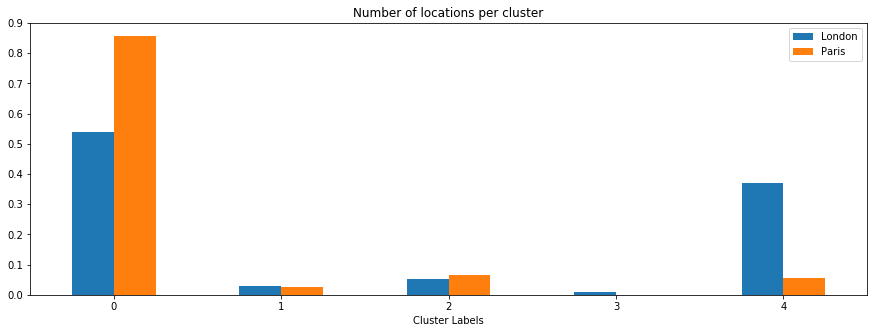

In [73]:
ax1 = df_comp.plot.bar(rot=0,figsize=(15,5))
ax1.set_title('Number of locations per cluster')

In [74]:
df_comp_pct=df_comp
df_comp_pct[['London', 'Paris']] = df_comp[['London', 'Paris']].apply(lambda x: x/x.sum(), axis=0)
df_comp_pct

,London,Paris
Cluster Labels,,
0,0.538835,0.857143
1,0.029126,0.024631
2,0.053398,0.064039
3,0.009709,NaN
4,0.368932,0.054187


Text(0.5, 1.0, 'Percentage split of locations per cluster')

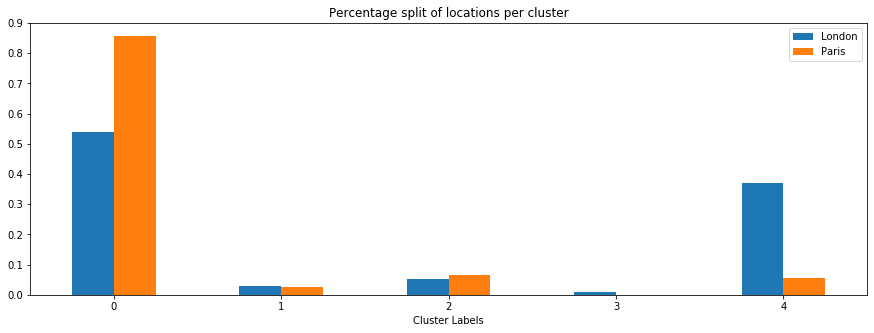

In [75]:
ax2 = df_comp_pct.plot.bar(rot=0,figsize=(15,5))
ax2.set_title('Percentage split of locations per cluster')

## 5. Discussion

We can conclude that the first category is the dominant category in areas of London and Paris too. This category represents central shopping areas good for people who would like to be in the centre of their neiborhoods. 

The biggest difference is that for London these location account for approximately half the areas of London. On the other hand for Paris the percentage is much higher close to 85%. 

This is probably because the prediction algorithm took out most of the areas of Paris as the common location with London were not satisfactory to make a prediction. But we will explain this at the end of this section.

From the sample reviewed, the second category (Cluster 1) being the decentralised areas are almost equally weighted for both cities at a level of 2.5-3.0%.

The third category (Cluster 2) being the areas near the parks are also almost equally weighted for the two cities. 

As mentioned earlier at the algorithm training paragraph, Cluster 2 and 3 should probably be the same category. This is also reflected in the fact that there were 0 predicted areas in Paris for Cluster 3.

Given this facts and assuming that these two clusters converge on the type of areas we can say that these clusters are similar in percentage content for the two cities. More specifically by adding the percentages they approximately 6.2-6.4%.

Again these results assumes that the sample reviewed can be representative.

Lastly, the last category (Cluster 4) is what looks to significantly differentiate the two cities. Cluster 4 is heavy in Pubs inclusion. This is a cultural element of the UK (and respectively London), which makes London so more different than the other cities of Europe. The content of pub doinated areas in London is 35-40% . On the other hand Paris only has approximately 5% of its areas being pub dominated.

In the process of completing this assignment we met a challenge; in some occassions the most popular places in London were completely different than popular areas in Paris and vice versa. This resulted to only use a small sample of mutually existing locations ("common_cols") to train the algorithm and predict the areas of Paris. This smaple obviously was not representative enough as in the process many areas of Paris were dropped. This is because there were not satisfactory mutually existing areas to use for the prediction. This limitation is something that we can look into exploring in the future to make the algorithm more resilient in predict areas which might have similarities but are not strictlyb identical.

## 6. Conclusions

In this assignment we developed an algorithm to predict the areas in Paris that are suitable of employeed who are currently located in London and need to move because of Brexit. This algorithm could be used by employers, real estate agents or other parties who are interested in providing advisory on such a switch of locations.

We came up with the results that the two cities are pretty similar in Neighborhood type content. However, their main difference is the cultural way of socialising and entertainment.Additionally this algorithm can be further developed to procide a more resilient way of prediction rather than the identical matching of locations.


## Disclaimer

This assignment was completed as part of the module "Applied Data Science Capstone". This module was completed as part of the "IBM Data Science Professional Certificate" provided on Coursera. The rights of this essay remain with its author and no copy or reproduction should be attepted without his written consent.